### Source: daijiro/flare_detect_V889 Her.ipynb


In [1]:
import os
import sys
import re
from pathlib import Path
from pprint import pprint

import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project:', PROJECT_ROOT)


Project: /Users/daisukeyamashiki/Documents/kyoto-flare-detection


In [2]:
from src.flarepy_V889_Her import FlareDetector_V889_Her

In [3]:
detectors_V889_Her = []
for file_path in sorted((PROJECT_ROOT / 'data/TESS/V889Her').glob('*.fits')):
    file_name = file_path.name

    # 正規表現を使ってセクター番号を抽出（ハイフンで区切られた部分から）
    match = re.search(r'-s\d{4}-', file_name)
    s_number = match.group(0)[1:-1] if match else None

    if not s_number:
        continue

    detector = FlareDetector_V889_Her(file=str(file_path), process_data=True)
    detectors_V889_Her.append(detector)

for detector in detectors_V889_Her:
    print(detector.file, detector.flare_number, detector.sum_flare_energy)


In [4]:
print(os.getcwd()) # 現在のディレクトリを表示

/Users/daisukeyamashiki/Documents/kyoto-flare-detection/notebooks


# EK_Dra のデータ１つに対してインスタンスを作成

- for ループで回してグラフを表示できるように辞書の中にインタンスを入れる
- 辞書のキーはファイル名から取得する
- 全ての計算処理は、インスタンス生成時に自動で行えるようにする。
- 途中の計算結果の配列は、インスタンス変数として全て保持するように`flarepy_improved.py`を変更した。
- 観測時間順に辞書をソートして、後で for ループで回してグラフを表示する際に観測時間順に表示できるようにする。


In [5]:
# "V889Her" フォルダーのパス。上の`print(os.getcwd())`の結果を参考に各自自分の環境に合わせて変更してください。
folder_path = PROJECT_ROOT / "data" / "TESS" / "V889_Her"

# フォルダー内のファイルリスト（Pathオブジェクトとして保持）
file_list = sorted(folder_path.glob("*.fits"))

# FlareDetectorインスタンスを格納するための辞書を作成
detectors = {}

# フォルダー内のファイルをループ処理
for file_path in file_list:
    file_name = file_path.name

    # 正規表現を使ってファイル名から "s" の後の4桁の数字を抽出
    # 例: "tess2018206045859-s0001-0000000027214766-0120-s_lc.fits" -> "s0001"
    match = re.search(r'-s\d{4}-', file_name)
    s_number = match.group(0)[1:-1] if match else None

    if not s_number:
        continue

    # 動的なインスタンス名を生成
    instance_name = f"detector_{s_number}"

    # FlareDetectorクラスのインスタンスを作成
    # process_data=True にすると、データの読み込みと処理が自動で行われる
    detector = FlareDetector_V889_Her(
        file=file_path,
        process_data=True,
        ene_thres_low=5e33,
        ene_thres_high=10e39,
    )

    # インスタンスを辞書に格納
    detectors[instance_name] = detector

# 観測時刻順にソート(lambda関数を使用）
# 各インスタンスのtessBJDの配列の最初の値が小さい順
detectors = dict(sorted(detectors.items(), key=lambda x: x[1].tessBJD[0]))

# 結果を確認
for name, instance in detectors.items():
    print(f"{name}: {instance}")

detector_s0026: <src.flarepy_V889_Her.FlareDetector_V889_Her object at 0x11a2e16a0>
detector_s0040: <src.flarepy_V889_Her.FlareDetector_V889_Her object at 0x11a356d50>
detector_s0053: <src.flarepy_V889_Her.FlareDetector_V889_Her object at 0x11a357250>
detector_s0080: <src.flarepy_V889_Her.FlareDetector_V889_Her object at 0x11a356e90>


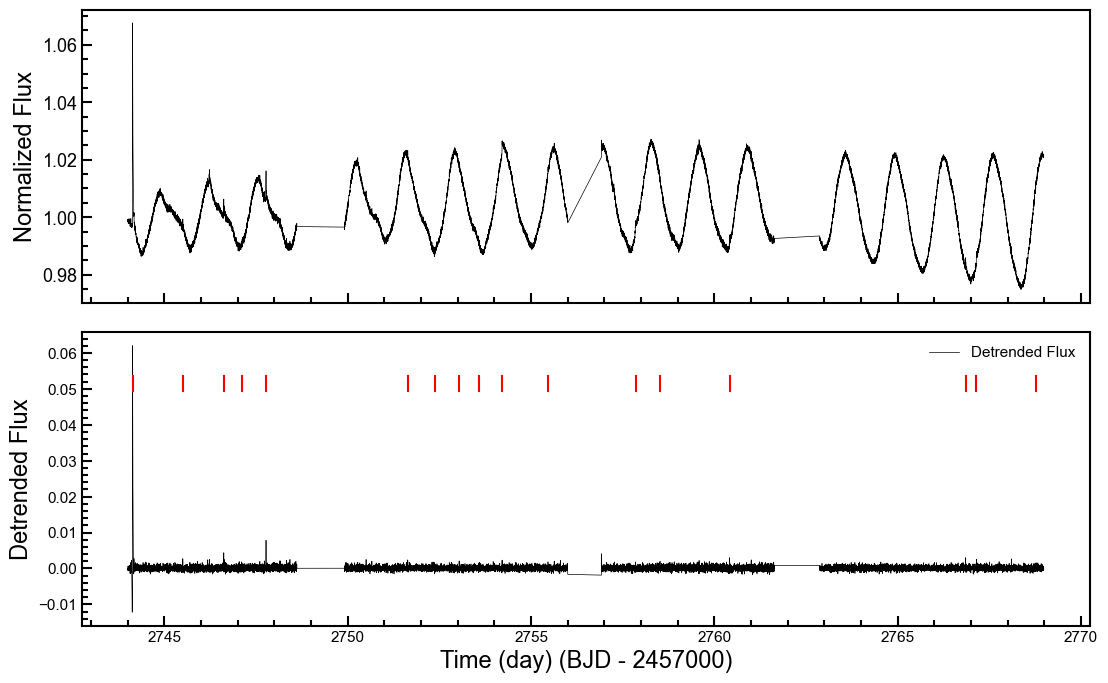

In [6]:
tessBJD = detectors["detector_s0053"].tessBJD
mPDCSAPflux = detectors["detector_s0053"].mPDCSAPflux
s2mPDCSAPflux = detectors["detector_s0053"].s2mPDCSAPflux
peaktime = detectors["detector_s0053"].peaktime

plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"]=True
plt.rcParams["ytick.minor.visible"]=True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# 2つのサブプロットを作成 (生の光度曲線とデトレンド後)
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13, 8))
fig.subplots_adjust(hspace=0.1) # サブプロット間の垂直方向のスペースを調整

# 1つ目のサブプロット: 生の光度曲線
axs[0].plot(tessBJD, mPDCSAPflux, color="black", linestyle="-", label="Normalized Flux", lw=0.5)
axs[0].set_ylabel("Normalized Flux", fontsize=17)
axs[0].tick_params(labelsize=13)
#axs[0].legend(loc='upper right', fontsize=11).get_frame().set_alpha(0)
#axs[0].title(title, fontsize=17)
# 2つ目のサブプロット: デトレンド後
if s2mPDCSAPflux is not None:
    axs[1].plot(tessBJD, s2mPDCSAPflux, color="black", linestyle="-", label="Detrended Flux" , lw=0.5)

    # フレアのピーク位置を線で示す
    if peaktime is not None:
        ymin=np.max(s2mPDCSAPflux*1.1)
        ymax=np.max(s2mPDCSAPflux*1.3)
        for peak in peaktime:
            # ここでのy座標の範囲は適宜調整してください。
            # Plotlyのy=[0.023, 0.0243]は相対的な範囲なので、
            # Matplotlibではデータに合わせて絶対的なy軸の範囲を考慮する必要があります。
            # 例として、y軸の最小値から少し上の範囲を仮定しています。
            axs[1].axvline(x=peak, ymin=0.8, ymax=0.85, color="red", linestyle="-", linewidth=1.5)
            # もしデータに合わせてy座標を調整したい場合は、以下のようにすることもできます。
            # axs[1].plot([peak, peak], [min_flux_val * 1.02, min_flux_val * 1.05]
            #             color="red", linestyle="--", linewidth=1)


    axs[1].set_xlabel(f'Time (day) (BJD - 2457000)', fontsize=17) # Plotlyに合わせてラベルを修正
    axs[1].set_ylabel("Detrended Flux", fontsize=17)
    axs[1].tick_params(labelsize=13)
    #axs[1].legend(loc='upper right', fontsize=11).get_frame().set_alpha(0)
    plt.tick_params(labelsize=11)
    leg = plt.legend(loc='upper right', fontsize=11)
    leg.get_frame().set_alpha(0)  # 背景を完全に透明にする
    plt.savefig(PROJECT_ROOT / 'outputs' / 's0053_V889Her_lightcurve.pdf', format='pdf', bbox_inches='tight')

# 使い方

### 上のセルで計算は全て終わっているので、欲しい値を取得するだけで良い。

- `show_variables()`メゾットで取得できる値の一覧を表示できる。
- `detectors["detector_s0021"]`と、辞書のキーを指定することでデータのインスタンスを選ぶことができる。
- 全てのデータについて一気に見たい時は以下のようにする。

```
for instance in detectors.values():
    instance.tessBJD # インスタンス変数は`instance.変数名`で取得できる
    instance.plot_flare() # インスタンスメゾットは`instance.メゾット名()`で呼び出せる
```

### 以下のメゾットを使うことができる。（`flarepy_improved.py`で定義）

- `plot_flare()`メゾットでフレアの生データと検出されたフレアのグラフを表示できる。
- `plot_energy()`メゾットでフレアのエネルギーのグラフを表示できる。

### クラス変数を使って、全てのインスタンスのフレアの検出割合を集計している。

- `array_flare_ratio`内に、フレアの検出割合を集計
- `array_observation_time`内に、観測時間を集計


In [7]:
sum_flare_number = 0.0
sum_obs_time = 0.0
for detector in detectors.values():
    sum_flare_number += detector.flare_number
    sum_obs_time += detector.precise_obs_time
print(sum_flare_number)
print(sum_obs_time)
frequency = sum_flare_number/sum_obs_time
print(frequency)

40.0
90.94469412109788
0.4398277479138892


In [8]:
sflux = np.array([])
for  detector in detectors.values():
  sflux = np.append(
    sflux , detector.mPDCSAPflux * detector.flux_mean)
  ave = np.mean(sflux)
  print(f"mean={detector.flux_mean}")
print(ave)

mean=300710.62334465684
mean=300710.62334465684
mean=300710.62334465684
mean=300710.62334465684
300710.6233547328


In [9]:
for  detector in detectors.values():
  detector.plot_flare()

In [10]:
for  detector in detectors.values():
  detector.plot_energy()

In [11]:
detectors["detector_s0026"].flare_number

np.int64(15)

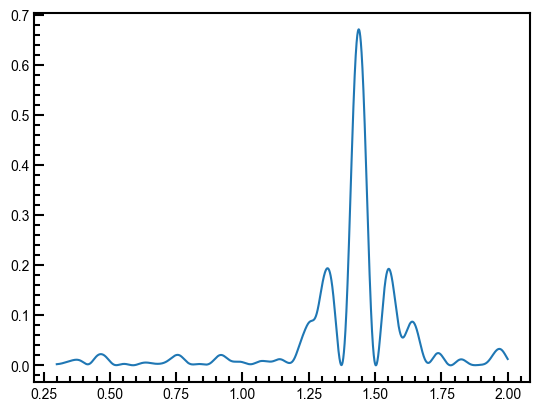

In [12]:
import matplotlib.pyplot as plt
#2.4～3.0を1000等分して、その中のどれが自転周期なのかを探す
frequency = 1/np.linspace(0.3,2.0,10000)
total_power = np.array([])
for  detector in detectors.values():
    total_power = np.append(
        total_power, detector.power
    )
period = 1/frequency
plt.plot(period, detectors["detector_s0080"].power)


In [13]:
print(detectors.keys())


dict_keys(['detector_s0026', 'detector_s0040', 'detector_s0053', 'detector_s0080'])


In [14]:
if "detector0026" in detectors:
    plt.plot(1/frequency, detectors["detector0026"].power)
else:
    print("Key 'detector0026' does not exist in detectors.")


Key 'detector0026' does not exist in detectors.


In [15]:
total_bjd = np.array([])
total_flux = np.array([])*100-100
for  detector in detectors.values():
    total_bjd = np.append(
        total_bjd, detector.tessBJD
    )
    total_flux = np.append(
        total_flux, detector.mPDCSAPflux
    )

diff_bjd = np.diff(total_bjd)
gap_indices = np.where(diff_bjd >= 0.2)[0]

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    total_bjd[exclude_index] = np.nan
    total_flux[exclude_index] = np.nan
    fig.add_trace(
    go.Scatter(
        x=[total_bjd[exclude_index]],
        y=[total_flux[exclude_index]],
        mode="markers",
        marker=dict(color="blue", size=1),
        name="Excluded Point"
    ),
    row=1,
    col=1,
    )

fig.add_trace(
    go.Scatter(
        x=total_bjd,
        y=total_flux,
        mode="lines",
        line=dict(color="blue", width=1),
        name="Flux Line"
    ),
    row=1,
    col=1,
)

fig.update_layout(
    xaxis_range = [2010,3510],

    xaxis_title={
        'text':"時間(日)",
        'font':{
            'size':  50
        }
    },
    yaxis_title={
        'text':"平均の明るさに対する明るさ(%)",
        'font':{
            'size':  35
        }
    },
    xaxis={
        'tickfont': {
            'size': 30
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    height=500,width=1700
)

fig.show()

In [16]:
time = detectors["detector_s0026"].tessBJD
flux = detectors["detector_s0026"].mPDCSAPflux*100

diff_bjd = np.diff(detectors["detector_s0026"].tessBJD)
gap_indices = np.where(diff_bjd >= 0.2)[0]

time_excluded = time.copy()
flux_excluded = flux.copy()

fig = make_subplots(rows=1, cols=1)

for i in range(len(gap_indices)):
    exclude_index = gap_indices[i]
    time_excluded[exclude_index] = np.nan
    flux_excluded[exclude_index] = np.nan
    fig.add_trace(
    go.Scatter(
        x=[time[exclude_index]],
        y=[flux[exclude_index]],
        mode="markers",
        marker=dict(color="blue", size=1),
        name="Excluded Point"
    ),
    row=1,
    col=1,
    )

fig.add_trace(
    go.Scatter(
        x=time_excluded,
        y=flux_excluded,
        mode="lines",
        line=dict(color="blue", width=1),
        name="Flux Line"
    ),
    row=1,
    col=1,
)

fig.update_layout(

    xaxis_title={
        'text':"時間(日)",
        'font':{
            'size':  50
        }
    },
    yaxis_title={
        'text':"平均の明るさに対する割合(%)",
        'font':{
            'size':  40
        }
    },
    xaxis={
        'tickfont': {
            'size': 30
        }
    },

    yaxis={
        'tickfont': {
            'size': 30
        }
    },
    showlegend=False,
    title=dict(text="図1. EK Draの明るさの変動", font=dict(size=40) ,x=0.5,y=0.94 ),
    height=700,width=1300
)

fig.show()
